# Olivine Diffusion

Olivine is one of the most important mineral composition the upper mantle and controlling its rheology as well as seismic and eletric properties. Several studies pointed the role of water on the properties of olivine, and, hence, on those of the mantle. Despite such importance, it turns out that we do not have a consensus on the way water is stored and diffuse in olivine, as this is a very complex process.

Water diffusion in olivine seems to be linked to its diffusion in various point defects, namely Si and Mg vacancies as well as in Mg vacancies in association with trivalent cations like Al$^{3+} or Fe$^{3+}$, or forming a Ti-clinohumite like point defect.

In this notebook, we will see if we can see such association in a forsterite crystal that has been hydroxylated during an experiment in a piston-cylinder. The experiment lasted 48 hours at 1400 °C and 1.5 GPa. How water diffuses in those conditions in the Fo crystal ?

# Diffusion in olivine

We can study this question as an speudo-equilibrium is rapidly established at the boundary of our olivine crystal, imposing a concentration $c_0$ at the boundary (faces of our crystal, a cube of 1x1x1 mm)

To study the diffusive process, we can use the Fick equations. In particular, the second law of Fick allows describing the variation of the concentration of a substance in a media given time. In one dimension, we have:

$ \frac{\partial c}{\partial t} $ = D $ \frac{\partial^2 c }{\partial x^2} $ .   (eq. 1)

Assuming a constant concentration $c_0$ at $x$ = 0, a simple solution is given by : 

$ c(x,t) = c_0 \text{erfc}({\frac{x}{2\sqrt{Dt}}})$ . (eq. 2)

Represent below the profil of concentration at t = 0 h, t = 12 h, t = 24 h and t = 48 h.

*Tips: (1) erfc function is provided by scipy.special; (2) t=0 does not work, but you can use t=0.000001 as an approximation.*

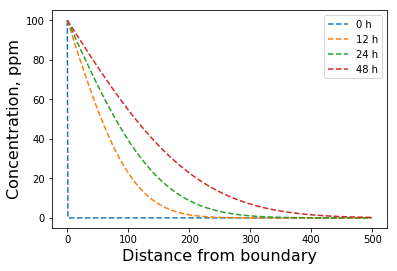

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from scipy.special import erfc

def diff(x,t,D,c0):
    """1D solution to Fick second law"""
    return c0*erfc(x/(2*np.sqrt(D*t)))

x = np.arange(0,500,1.0) # Notre profil de la bordure au centre

x0 = 100.0 # ppm, la concentration en eau à la bordure

D = 10**-13.1 # m2 s-1, le coefficient de diffusion à la température de travail, 1400 °C

plt.plot(x, diff(x*1e-6,0.00001*3600,D,100.0),"--",label="0 h")
plt.plot(x, diff(x*1e-6,12*3600,D,100.0),"--",label="12 h")
plt.plot(x, diff(x*1e-6,24*3600,D,100.0),"--",label="24 h")
plt.plot(x, diff(x*1e-6,48*3600,D,100.0),"--",label="48 h")
plt.xlabel("Distance from boundary",fontsize=16)
plt.ylabel("Concentration, ppm",fontsize=16)
plt.legend()

# Application to real-world data

You will find two files with concentrations in Al, Fe, Sc... measured by LA-ICP-MS after one experiments. Hit: conditions are in the filename...

Using the equation presented above, try to : 
- fit those data and determine the diffusion coefficients of those elements; 
- provide sensible errors bars for the parameters, and propagate them on the fit solution. 
- Re-do the above graph for all elements with errors bars

Index(['ElapsedTime_s', 'Distance', 'Si29_CPS', 'Mg_ppm_m25', 'Al_ppm_m27',
       'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195'],
      dtype='object')
Index(['ElapsedTime_s', 'Distance', 'Si29_CPS', 'Mg_ppm_m25', 'Al_ppm_m27',
       'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195'],
      dtype='object')


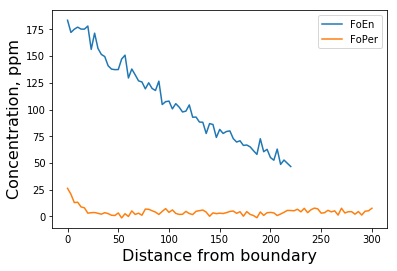

In [2]:
data_1400C_192h_FoEn = pd.read_csv("16C_ICP1_1400C_axisC_192h_FoEn.csv")
print(data_1400C_192h_FoEn.columns)
data_1400C_192h_FoPer = pd.read_csv("16B_ICP2_1400C_axisC_192h_FoPer.csv")
print(data_1400C_192h_FoPer.columns)

plt.plot(data_1400C_192h_FoEn.Distance,data_1400C_192h_FoEn.Fe_ppm_m57,label="FoEn")
plt.plot(data_1400C_192h_FoPer.Distance,data_1400C_192h_FoPer.Fe_ppm_m57,label="FoPer")
plt.xlabel("Distance from boundary",fontsize=16)
plt.ylabel("Concentration, ppm",fontsize=16)
plt.legend()

t_exp = 192.0*3600
x_obs_1 = data_1400C_192h_FoEn.Distance
y_obs_1 = data_1400C_192h_FoEn.Fe_ppm_m57
ese_obs_1 = np.std(data_1400C_192h_FoEn.Fe_ppm_m57[0:10])*np.ones(len(x_obs_1))

# Here are all the functions necessary for the optimisation procedure

In [4]:
def llf(x,mu,sigma):
    return -0.5*np.sum((x-mu)**2/sigma**2 + np.log(np.pi*2*sigma**2))

def loglike(theta,x,t,y,ese):
    D,c0 = theta
    return llf(diff2(x,t,D,c0),y,ese)

def logprior(theta):
    D,c0 = theta
    if c0 > 0:
        return 0
    else:
        return -np.inf
    
def logprob(theta,x,t,y,ese):
    return logprior(theta) + loglike(theta,x,t,y,ese)

def diff2(x,t,D,c0):
    """1D solution to Fick second law"""
    return c0*erfc(x*1e-6/(2*np.sqrt(10**D*t)))

def diff_forcf(x,D,c0):
    """1D solution to Fick second law"""
    return c0*erfc(x[:,0]*1e-6/(2*np.sqrt(10**D*x[0,1])))

# Finding a optimal value of the PPD with using scipy.optimize

In [6]:
from scipy.optimize import minimize, curve_fit
import emcee

theta0 = [-13.0, 100.0]

print(logprob(theta0,x_obs_1,t_exp,y_obs_1,ese_obs_1))

nll = lambda *args: -logprob(*args) # anonymous function to transform the logprob in least-square criterion

result = minimize(nll, theta0, args=(x_obs_1,t_exp,y_obs_1,ese_obs_1))

-1101.5353947348055


# Sampling the logprob with EMCEE

In [7]:
ndim, nwalkers = 2, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=(x_obs_1,t_exp,y_obs_1,ese_obs_1))
sampler.run_mcmc(pos, 500)

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
y_samples = np.zeros((len(x_obs_1),100))
for i in range(100):
    y_samples[:,i] = diff2(x_obs_1,t_exp,samples[i,0],samples[i,1])

# Final plot

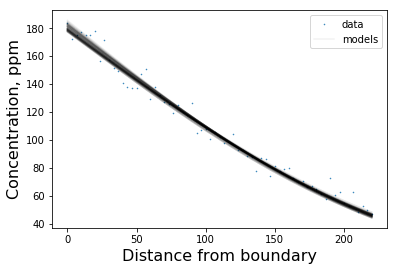

In [8]:
plt.plot(x_obs_1,y_obs_1,".",markersize=1,label="data")

plt.plot(x_obs_1,y_samples[:,0],"-",color="black",alpha=0.05,label="models")
plt.legend()

plt.plot(x_obs_1,y_samples,"-",color="black",alpha=0.05)

plt.xlabel("Distance from boundary",fontsize=16)
plt.ylabel("Concentration, ppm",fontsize=16)

plt.show()

In [9]:
print("estimated D is of {}".format(np.mean(samples[:,0])))
print("estimated c0 is of {}".format(np.mean(samples[:,1])))

estimated D is of -13.552936037955133
estimated c0 is of 179.43596065492784


# Histogram of model parameters

This will help us assess the big question: what is the distribution of the parameter errors ?

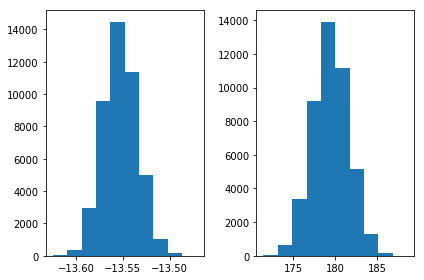

In [10]:
plt.subplot(1,2,1)
plt.hist(samples[:,0])
plt.subplot(1,2,2)
plt.hist(samples[:,1])

plt.tight_layout()